# 3. LSTM Model for Sentiment Classification

- In this notebook,A RNN using an LSTM layer will be trained to classify movie reviews as positive or negative.
- notebook Structure contains of 2 main sections based on the version of the data.each section have 3 subsection as follows:

1. **Part One : LSTM on Raw Text**:unprocessed data directly from the original IMDB reviews:
  - Reading The Raw Data from MyDrive
  - Split The raw data
  - LSTM training on the Raw data
  - Evaluations on the raw data


```
# Note : the raw data set name is "df" and train text val sets are named the same
 as the next section as each will be re initialized in the next section so naming them
 the same does not mean they have same values.
```



2. **Part Two : LSTM on the Processed Set**: the cleaned and lemmatized reviews from Task 1:
  -  Reading The Processed Data from MyDrive
  - Split Processed data
  - LSTM training on the Processed data
  - Evaluations on the processed data



The goal is to compare performance when using unprocessed versus processed inputs.


```
# Note : the processed data name in this section is "df_processed"
```



---

## What “variable-length inputs” means

Most neural networks expect inputs of the same size, but sentences and reviews naturally come in all lengths—from a few words to several paragraphs.  
“Variable-length input” simply means feeding each review in its own length (after tokenizing), rather than truncating or padding everything to a fixed size up front.  


---



```
There is a comparison of results section at the end of the notebook between the two parts. here is a brief about the results:

The Processed-text Dropout Baseline achieves slightly lower overall accuracy
but delivers higher recall and a lower false negative rate, so its more
effective at identifying positive reviews. Its F1-score is almost identical to
the raw-text model. Deciding between the two models comes down to whether
minimizing overall errors or maximizing the detection of positive cases is the
higher priority.
```



Note : to run the notebook access these data links and put them on MyDrive destination so you got no errors:

- https://drive.google.com/file/d/1vAcjI1BLEzjdqfSwcrwDWXIkw10DSgK6/view?usp=sharing

- https://drive.google.com/file/d/1PLoYC8owKyqwUpO9Td9mJC23JZ9zU1Cr/view?usp=sharing

In an attempt to increase accuracy, a variety of LSTM architectures were investigated, including deeper stacks, bidirectional layers, additional dense bottlenecks, and different dropout schemes. However, almost instantly, each of those models started to overfit, with training accuracy outperforming test accuracy by 6–10 percentage points. . In contrast, the final dropout‐regularized LSTM maintained almost identical performance across train, validation, and test splits (only a 2–3 pp accuracy gap and marginal loss increases), demonstrating stable generalization through the third epoch and effectively preventing overfitting.



```

```



In [1]:
# Fix notebook seed to get same results whenever running the notebook again
import tensorflow as tf

# ensure TF ops & initial weights are deterministic
SEED=42
tf.random.set_seed(SEED)


# Part One : LSTM on Raw Text

## Reading The Raw Data from MyDrive
"The data have been Previously uploaded to MyDrive"

In [2]:
# mount or connect to drive to get the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
# file path on MyDrive
file_path = '/content/drive/My Drive/IMDB Dataset.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

## Split The raw data

In [4]:
# split raw reviews into train+val (80%) and test (20%), stratified by label
from sklearn.model_selection import train_test_split

X_raw = df['review']
y     = df['sentiment']

X_temp, X_test, y_temp, y_test = train_test_split(
    X_raw, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# split the 80% temp into train (70% total) and val (10% total)
# val_size=0.125 because 0.125 * 0.80 = 0.10 of the original dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.125,
    random_state=SEED,
    stratify=y_temp
)

print(f"Train size: {len(X_train)} ({len(X_train)/len(df):.0%})")
print(f"Val   size: {len(X_val)} ({len(X_val)/len(df):.0%})")
print(f"Test  size: {len(X_test)} ({len(X_test)/len(df):.0%})")


Train size: 35000 (70%)
Val   size: 5000 (10%)
Test  size: 10000 (20%)


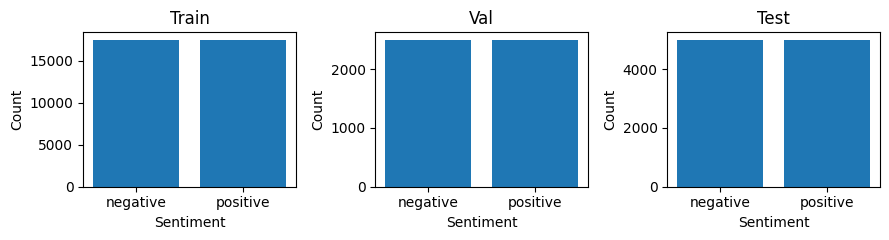

In [5]:
import matplotlib.pyplot as plt

# side-by-side bar charts for Train, Val, Test splits
fig, axs = plt.subplots(1, 3, figsize=(9, 2.5), tight_layout=True)

for ax, (name, labels) in zip(axs, [("Train", y_train), ("Val", y_val), ("Test", y_test)]):
    counts = labels.value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(name)
    ax.set_xlabel("Sentiment")
    ax.set_ylabel("Count")

plt.show()




```
as shown in the plots stratify split keep the distribution of the target classes count the same as the original data
```



##LSTM training on the Raw data

---



In [6]:
# ——— Quick Dropout Baseline LSTM on Processed Text ———

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Embedding, Dropout, LSTM, Dense
from tensorflow.keras.datasets   import imdb
from tensorflow.keras.optimizers import Adam





```
# the choice of tokenizer is Keras’s built-in Tokenizer, configured with a
fixed vocabulary size (num_words=5000), lowercase conversion (lower=True), and
an out-of-vocabulary token (oov_token='<OOV>'), and this tokenizer does
word-level splitting by applying its default filters to strip punctuation,
converts every token to lowercase, assigns each unique word an integer index
based on frequency, and replaces any rare or unseen word with the <OOV>
token—resulting in clean, integer-encoded sequences that can be uniformly
padded and fed directly into the LSTM.
```



Note for Padding : the variable length input handled by first converting each review into a
sequence of word indices and then padding shorter sequences with zeros up to a
chosen maximum length, while using the Embedding layer with mask_zero=True so
the LSTM automatically ignores any padded positions—this lets the model process
each review for exactly as many time steps as there are real words, effectively
treating every review at its own true length without bias from the padding.


In [7]:
#  Tokenize & pad (only top 5,000 words, maxlen=500)
top_words       = 5000
max_review_len  = 500

tokenizer_drop  = Tokenizer(num_words=top_words, lower=True, oov_token='<OOV>')
tokenizer_drop.fit_on_texts(X_train)           # use your processed X_train

X_drop_train = pad_sequences(
    tokenizer_drop.texts_to_sequences(X_train),
    maxlen=max_review_len
)
X_drop_val   = pad_sequences(
    tokenizer_drop.texts_to_sequences(X_val),
    maxlen=max_review_len
)
X_drop_test  = pad_sequences(
    tokenizer_drop.texts_to_sequences(X_test),
    maxlen=max_review_len
)




In [8]:
#  Build the model with embedding→dropout→LSTM(100)→dropout→Dense
model_drop = Sequential([
    Embedding(top_words, 32, input_length=max_review_len),
    Dropout(0.2),              # drop 20% of embeddings
    LSTM(100),                 # 100 LSTM units
    Dropout(0.2),              # drop 20% of LSTM outputs
    Dense(1, activation='sigmoid')
])

model_drop.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_drop.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Encode labels as 0/1
label_map_drop   = {'negative':0,'positive':1}
y_train_drop_enc = y_train.map(label_map_drop).values
y_val_drop_enc   = y_val.map(label_map_drop).values
y_test_drop_enc  = y_test.map(label_map_drop).values



In [10]:
# Train for only 3 epochs (to prevent overfitting)
history_drop = model_drop.fit(
    X_drop_train, y_train_drop_enc,
    validation_data=(X_drop_val, y_val_drop_enc),
    epochs=3,
    batch_size=64,
    verbose=2
)



Epoch 1/3
547/547 - 18s - 34ms/step - accuracy: 0.6391 - loss: 0.6107 - val_accuracy: 0.8288 - val_loss: 0.4106
Epoch 2/3
547/547 - 17s - 31ms/step - accuracy: 0.8481 - loss: 0.3650 - val_accuracy: 0.8644 - val_loss: 0.3227
Epoch 3/3
547/547 - 21s - 38ms/step - accuracy: 0.8841 - loss: 0.2911 - val_accuracy: 0.8822 - val_loss: 0.2904


## Evaluations on the raw data

In [11]:
#  Final evaluation on test set
loss_drop, acc_drop = model_drop.evaluate(X_drop_test, y_test_drop_enc, verbose=0)
print(f"Dropout Baseline Test Accuracy: {acc_drop*100:.2f}%")

Dropout Baseline Test Accuracy: 88.47%


In [12]:
# evaluate dropout baseline on train, val, and test sets in one go
train_loss, train_acc = model_drop.evaluate(X_drop_train, y_train_drop_enc, verbose=0)
val_loss,   val_acc   = model_drop.evaluate(X_drop_val,   y_val_drop_enc,   verbose=0)
test_loss,  test_acc  = model_drop.evaluate(X_drop_test,  y_test_drop_enc,  verbose=0)

print(f"Train → Loss: {train_loss:.3f}, Acc: {train_acc:.3f}")
print(f"Val   → Loss: {val_loss:.3f}, Acc: {val_acc:.3f}")
print(f"Test  → Loss: {test_loss:.3f}, Acc: {test_acc:.3f}")


Train → Loss: 0.256, Acc: 0.902
Val   → Loss: 0.290, Acc: 0.882
Test  → Loss: 0.288, Acc: 0.885


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy:              0.885
False Positive Rate:   0.085
False Negative Rate:   0.145
F1-score:              0.881
Recall:                0.855


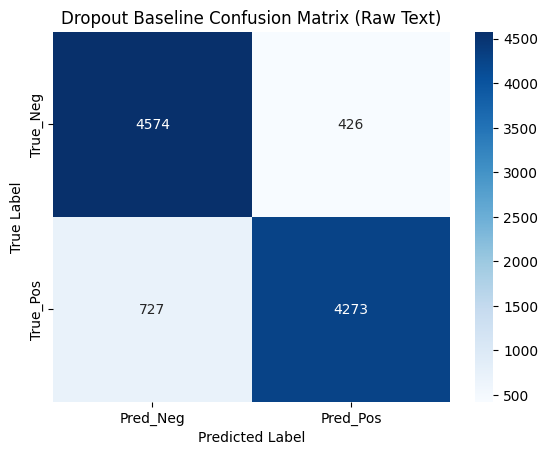

In [13]:
# Raw‐text Dropout Baseline Evaluation
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get test predictions
y_prob_drop = model_drop.predict(X_drop_test).ravel()
y_pred_drop = (y_prob_drop >= 0.5).astype(int)

# Compute confusion matrix and basic rates
cm_drop = confusion_matrix(y_test_drop_enc, y_pred_drop)
tn, fp, fn, tp = cm_drop.ravel()

accuracy_drop = (tp + tn) / cm_drop.sum()
fpr_drop      = fp / (fp + tn)
fnr_drop      = fn / (fn + tp)
f1_drop       = f1_score(y_test_drop_enc, y_pred_drop)
recall_drop   = recall_score(y_test_drop_enc, y_pred_drop)

# Print metrics
print(f"Accuracy:              {accuracy_drop:.3f}")
print(f"False Positive Rate:   {fpr_drop:.3f}")
print(f"False Negative Rate:   {fnr_drop:.3f}")
print(f"F1-score:              {f1_drop:.3f}")
print(f"Recall:                {recall_drop:.3f}")

# Plot confusion matrix
sns.heatmap(cm_drop, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Pred_Neg','Pred_Pos'],
            yticklabels=['True_Neg','True_Pos'])
plt.title('Dropout Baseline Confusion Matrix (Raw Text)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#Part Two : LSTM on the Processed Set

## Reading The Processed Data from MyDrive
"The data have been Previously uploaded to MyDrive"

In [14]:
# mount or connect to drive to get the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Read the data
import pandas as pd
file_path = '/content/drive/MyDrive/preprocessed_reviews.csv'
df_processed = pd.read_csv(file_path)

## Split Processed data

In [16]:
# split raw reviews into train+val (80%) and test (20%), stratified by label
from sklearn.model_selection import train_test_split

X_raw = df_processed['review']
y     = df_processed['sentiment']

X_temp, X_test, y_temp, y_test = train_test_split(
    X_raw, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# split the 80% temp into train (70% total) and val (10% total)
# val_size=0.125 because 0.125 * 0.80 = 0.10 of the original dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.125,
    random_state=SEED,
    stratify=y_temp
)

print(f"Train size: {len(X_train)} ({len(X_train)/len(df_processed):.0%})")
print(f"Val   size: {len(X_val)} ({len(X_val)/len(df_processed):.0%})")
print(f"Test  size: {len(X_test)} ({len(X_test)/len(df_processed):.0%})")


Train size: 35000 (70%)
Val   size: 5000 (10%)
Test  size: 10000 (20%)


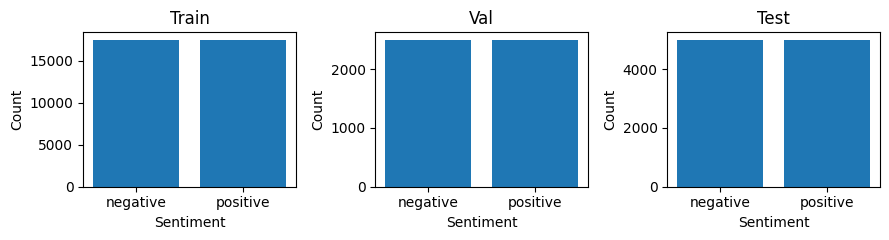

In [17]:
import matplotlib.pyplot as plt

# side-by-side bar charts for Train, Val, Test splits
fig, axs = plt.subplots(1, 3, figsize=(9, 2.5), tight_layout=True)

for ax, (name, labels) in zip(axs, [("Train", y_train), ("Val", y_val), ("Test", y_test)]):
    counts = labels.value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(name)
    ax.set_xlabel("Sentiment")
    ax.set_ylabel("Count")

plt.show()




```
as shown in the plots stratify split keep the distribution of the target classes count the same as the original data
```



##LSTM training on the Processed data

In [18]:
# ——— Quick Dropout Baseline LSTM on Processed Text ———

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Embedding, Dropout, LSTM, Dense
from tensorflow.keras.datasets   import imdb
from tensorflow.keras.optimizers import Adam



In [19]:
# Tokenize & pad (only top 5,000 words, maxlen=500)
top_words       = 5000
max_review_len  = 500

tokenizer_drop  = Tokenizer(num_words=top_words, lower=True, oov_token='<OOV>')
tokenizer_drop.fit_on_texts(X_train)           # use your processed X_train

X_drop_train = pad_sequences(
    tokenizer_drop.texts_to_sequences(X_train),
    maxlen=max_review_len
)
X_drop_val   = pad_sequences(
    tokenizer_drop.texts_to_sequences(X_val),
    maxlen=max_review_len
)
X_drop_test  = pad_sequences(
    tokenizer_drop.texts_to_sequences(X_test),
    maxlen=max_review_len
)




In [20]:
# Build the model with embedding→dropout→LSTM(100)→dropout→Dense
model_drop = Sequential([
    Embedding(top_words, 32, input_length=max_review_len),
    Dropout(0.2),              # drop 20% of embeddings
    LSTM(100),                 # 100 LSTM units
    Dropout(0.2),              # drop 20% of LSTM outputs
    Dense(1, activation='sigmoid')
])

model_drop.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
model_drop.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Encode labels as 0/1
label_map_drop   = {'negative':0,'positive':1}
y_train_drop_enc = y_train.map(label_map_drop).values
y_val_drop_enc   = y_val.map(label_map_drop).values
y_test_drop_enc  = y_test.map(label_map_drop).values



In [22]:
#  Train for only 3 epochs (to prevent overfitting)
history_drop = model_drop.fit(
    X_drop_train, y_train_drop_enc,
    validation_data=(X_drop_val, y_val_drop_enc),
    epochs=3,
    batch_size=64,
    verbose=2
)



Epoch 1/3
547/547 - 14s - 26ms/step - accuracy: 0.6685 - loss: 0.6019 - val_accuracy: 0.8188 - val_loss: 0.4279
Epoch 2/3
547/547 - 12s - 22ms/step - accuracy: 0.8509 - loss: 0.3590 - val_accuracy: 0.8616 - val_loss: 0.3313
Epoch 3/3
547/547 - 21s - 38ms/step - accuracy: 0.8790 - loss: 0.3007 - val_accuracy: 0.8722 - val_loss: 0.3076


## Evaluations on the processed data

In [23]:
# Final evaluation on test set
loss_drop, acc_drop = model_drop.evaluate(X_drop_test, y_test_drop_enc, verbose=0)
print(f"Dropout Baseline Test Accuracy: {acc_drop*100:.2f}%")

Dropout Baseline Test Accuracy: 86.97%


In [24]:
# evaluate dropout baseline on train, val, and test sets in one go
train_loss, train_acc = model_drop.evaluate(X_drop_train, y_train_drop_enc, verbose=0)
val_loss,   val_acc   = model_drop.evaluate(X_drop_val,   y_val_drop_enc,   verbose=0)
test_loss,  test_acc  = model_drop.evaluate(X_drop_test,  y_test_drop_enc,  verbose=0)

print(f"Train → Loss: {train_loss:.3f}, Acc: {train_acc:.3f}")
print(f"Val   → Loss: {val_loss:.3f}, Acc: {val_acc:.3f}")
print(f"Test  → Loss: {test_loss:.3f}, Acc: {test_acc:.3f}")


Train → Loss: 0.267, Acc: 0.895
Val   → Loss: 0.308, Acc: 0.872
Test  → Loss: 0.306, Acc: 0.870


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy:              0.870
False Positive Rate:   0.133
False Negative Rate:   0.127
F1-score:              0.870
Recall:                0.873


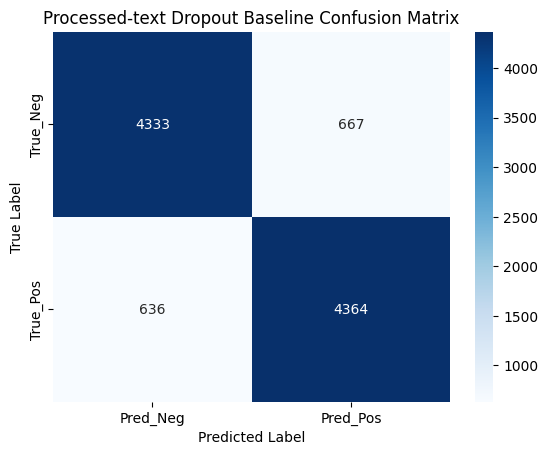

In [25]:
# Processed-text Dropout Baseline Evaluation
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# get test set predictions
y_prob_proc = model_drop.predict(X_drop_test).ravel()
y_pred_proc = (y_prob_proc >= 0.5).astype(int)

# build confusion matrix and unpack
cm_proc = confusion_matrix(y_test_drop_enc, y_pred_proc)
tn, fp, fn, tp = cm_proc.ravel()

# compute metrics
accuracy_proc = (tp + tn) / cm_proc.sum()
fpr_proc      = fp / (fp + tn)
fnr_proc      = fn / (fn + tp)
f1_proc       = f1_score(y_test_drop_enc, y_pred_proc)
recall_proc   = recall_score(y_test_drop_enc, y_pred_proc)

# print results
print(f"Accuracy:              {accuracy_proc:.3f}")
print(f"False Positive Rate:   {fpr_proc:.3f}")
print(f"False Negative Rate:   {fnr_proc:.3f}")
print(f"F1-score:              {f1_proc:.3f}")
print(f"Recall:                {recall_proc:.3f}")

# plot confusion matrix
sns.heatmap(cm_proc, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Pred_Neg','Pred_Pos'],
            yticklabels=['True_Neg','True_Pos'])
plt.title('Processed-text Dropout Baseline Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Final Comparison

In [26]:
import pandas as pd

# Compile the metrics into a table
metrics = {
    "Model": [
        "Raw-text Dropout Baseline",
        "Processed-text Dropout Baseline"
    ],
    "Accuracy": [0.885, 0.870],
    "FPR": [0.085, 0.133],
    "FNR": [0.145, 0.127],
    "F1-score": [0.881, 0.870],
    "Recall": [0.855, 0.873]
}

df_metrics = pd.DataFrame(metrics)

# Display the comparison table
print(df_metrics)


                             Model  Accuracy    FPR    FNR  F1-score  Recall
0        Raw-text Dropout Baseline     0.885  0.085  0.145     0.881   0.855
1  Processed-text Dropout Baseline     0.870  0.133  0.127     0.870   0.873




```
The comparison table shows that the Raw-text Dropout Baseline achieves slightly
higher overall accuracy (0.885 vs. 0.870) and a lower false positive rate (0.085 vs. 0.133),
at the cost of a higher false negative rate (0.145 vs. 0.127)
and lower recall (0.855 vs. 0.873). In contrast, the Processed-text Dropout
Baseline sacrifices a bit of accuracy for greater sensitivity—its improved
recall and reduced FNR indicate a stronger ability to identify positive
reviews, while maintaining an F1-score nearly identical to the raw-text model.
The appropriate selection therefore hinges on whether the priority is
minimizing total misclassifications or maximizing the detection of positive cases.

```



---

#Why I stopped training at the third epoch

after experimenting with numerous LSTM architectures—which all began to overfit almost immediately—this final dropout-based LSTM maintained matched training and validation performance through the third epoch. Beyond epoch three, the validation loss crept up and validation accuracy flattened out, clearly signaling the onset of overfitting. Stopping at that point therefore captured the model’s best generalization before its performance began to degrade.